In [1]:
import torch

print("Torch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("CUDA device count:", torch.cuda.device_count())
if torch.cuda.is_available():
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
    print(f"CUDA version: {torch.version.cuda}")
    print(f"Current device: {torch.cuda.current_device()}")
else:
    print("CUDA is NOT available. Using CPU!")


Torch version: 2.6.0+cu124
CUDA available: True
CUDA device count: 1
Using GPU: NVIDIA GeForce RTX 4060
CUDA version: 12.4
Current device: 0


In [1]:
import torch

if torch.cuda.is_available():
    print(f"GPU is available: {torch.cuda.get_device_name(0)}")
else:
    print("GPU is not available, using CPU.")


GPU is available: NVIDIA GeForce RTX 4060


In [ ]:

import torch
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments,
    EarlyStoppingCallback
)
from datasets import Dataset
import matplotlib.pyplot as plt
import seaborn as sns

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load dataset
file_path = "ENT_respiratory_neurological.csv"
df = pd.read_csv(file_path)
df = df.drop(columns=["Unnamed: 0"], errors="ignore")  # Drop unnecessary column if it exists
df["Symptoms"] = df["Symptoms"].str.lower().str.strip()  # Normalize text

# Map diseases to numerical labels
disease_to_id = {d: i for i, d in enumerate(df["Disease"].unique())}
id_to_disease = {i: d for d, i in disease_to_id.items()}
df["Label"] = df["Disease"].map(disease_to_id).astype(int)

# Train-test split
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df["Symptoms"].tolist(), df["Label"].tolist(), test_size=0.2, random_state=42
)

# Load BioBERT tokenizer and model directly from Hugging Face
model_name = "dmis-lab/biobert-v1.1"  # Example BioBERT model from Hugging Face
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(disease_to_id))

# Tokenization function
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)

# Convert to Hugging Face Dataset and tokenize
train_dataset = Dataset.from_dict({"text": train_texts, "labels": train_labels}).map(tokenize_function, batched=True)
test_dataset = Dataset.from_dict({"text": test_texts, "labels": test_labels}).map(tokenize_function, batched=True)




c:\Users\Admin\Desktop\fine_tuning\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-v1.1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|██████████| 6163/6163 [00:00<00:00, 17705.41 examples/s]


In [ ]:

# Define Training Arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=3,  # Keep last 3 best models
    per_device_train_batch_size=16,  # Adjusted batch size for stability
    per_device_eval_batch_size=16,
    num_train_epochs=10,  # Early stopping will halt before overfitting
    weight_decay=0.01,
    logging_dir="./logs",
    report_to="none",
    load_best_model_at_end=True,
    learning_rate=3e-5,  # Standard fine-tuning learning rate
    lr_scheduler_type="linear",  # Linear decay of learning rate
    warmup_ratio=0.1,  # 10% warmup
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    logging_steps=100,  # Log every 100 steps
    save_steps=200,  # Save every 200 steps
    eval_steps=200
)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]  # Stop if no improvement for 3 evaluations
)

# Train the model
trainer.train()

c:\Users\Admin\Desktop\fine_tuning\.venv\lib\site-packages\transformers\training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.332300,0.310441
2,0.276600,0.253545
3,0.229600,0.232224
4,0.215900,0.225595
5,0.185600,0.229816
6,0.207500,0.217056
7,0.178700,0.220817
8,0.176200,0.227176
9,0.187300,0.235644


TrainOutput(global_step=13869, training_loss=0.3390877567120452, metrics={'train_runtime': 2970.2641, 'train_samples_per_second': 82.996, 'train_steps_per_second': 5.188, 'total_flos': 1.4597780878162944e+16, 'train_loss': 0.3390877567120452, 'epoch': 9.0})

In [4]:
# Save the trained model
model.save_pretrained("./biobert_finetuned")
tokenizer.save_pretrained("./biobert_finetuned")

('./biobert_finetuned\\tokenizer_config.json',
 './biobert_finetuned\\special_tokens_map.json',
 './biobert_finetuned\\vocab.txt',
 './biobert_finetuned\\added_tokens.json',
 './biobert_finetuned\\tokenizer.json')

In [5]:
from sklearn.metrics import accuracy_score
import numpy as np

# Function to compute accuracy
def compute_accuracy(predictions, labels):
    preds = np.argmax(predictions, axis=1)  # Convert logits to class labels
    return accuracy_score(labels, preds)  # Compute accuracy

# Get Training Accuracy
train_predictions = trainer.predict(train_dataset)
train_accuracy = compute_accuracy(train_predictions.predictions, train_labels)
print(f"Training Accuracy: {train_accuracy:.4f}")

# Get Test Accuracy
test_predictions = trainer.predict(test_dataset)
test_accuracy = compute_accuracy(test_predictions.predictions, test_labels)
print(f"Test Accuracy: {test_accuracy:.4f}")


Training Accuracy: 0.9160


Test Accuracy: 0.8971


In [6]:
from sklearn.metrics import classification_report
import numpy as np

# Get Test Predictions
test_predictions = trainer.predict(test_dataset)
test_preds = np.argmax(test_predictions.predictions, axis=1)  # Convert logits to class labels

# Compute Precision, Recall, F1-score
report = classification_report(test_labels, test_preds, digits=4)
print("Test Precision, Recall, F1-score:\n")
print(report)


Test Precision, Recall, F1-score:

              precision    recall  f1-score   support

           0     0.8736    0.9755    0.9217       163
           1     0.8741    0.7225    0.7911       173
           2     0.9182    0.8588    0.8875       170
           3     0.8750    0.9211    0.8974       190
           4     0.6079    0.9086    0.7284       186
           5     1.0000    0.9563    0.9777       252
           6     1.0000    0.9959    0.9980       245
           7     0.6685    0.6836    0.6760       177
           8     0.9050    0.9141    0.9095       198
           9     1.0000    0.8734    0.9324       229
          10     0.9738    0.9253    0.9489       241
          11     0.8821    0.7829    0.8296       258
          12     0.9295    0.9218    0.9256       243
          13     1.0000    0.9568    0.9779       185
          14     1.0000    1.0000    1.0000       237
          15     0.9681    0.9286    0.9479       196
          16     0.9552    0.9181    0.9363   

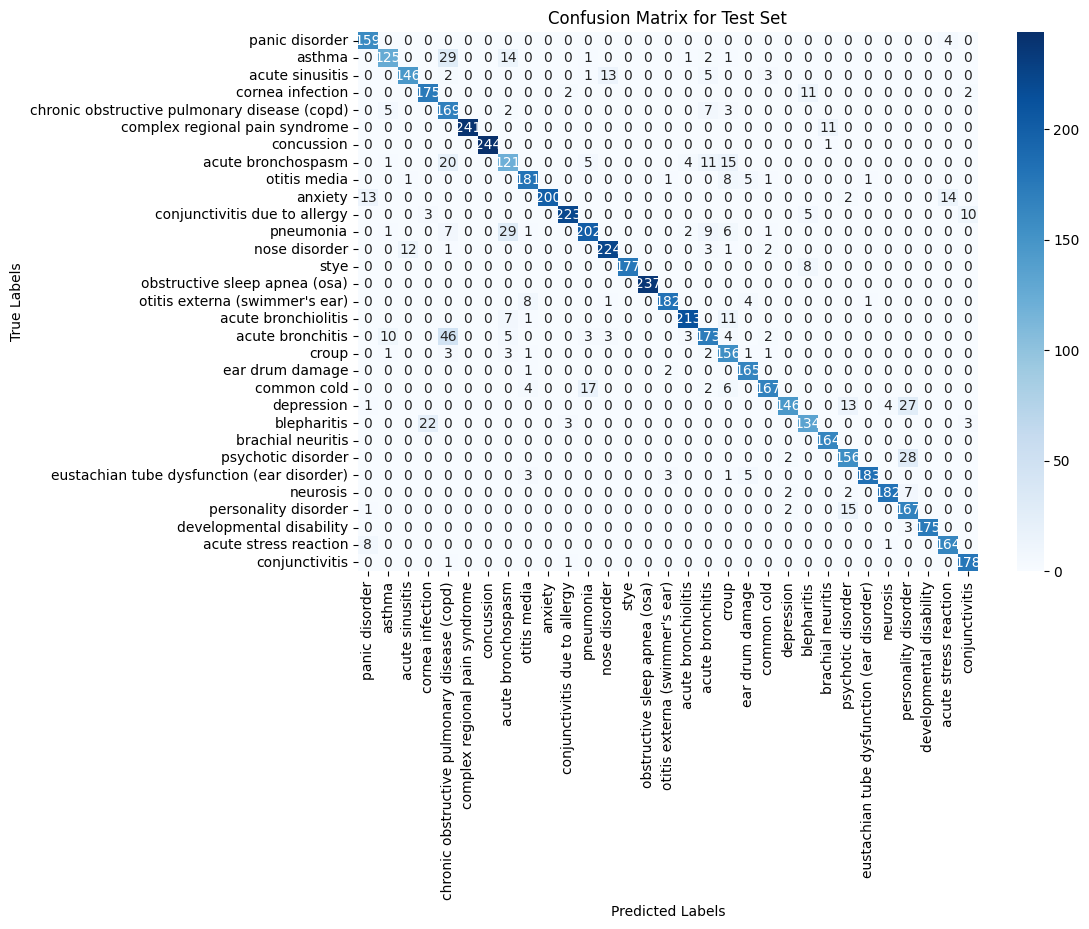

In [7]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get predictions on the test dataset
predictions = trainer.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=1)

# Compute confusion matrix
cm = confusion_matrix(test_labels, preds)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=disease_to_id.keys(), yticklabels=disease_to_id.keys())
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix for Test Set")
plt.show()


In [1]:
# Function to predict disease from user symptoms
def predict_disease(symptoms):
    inputs = tokenizer(symptoms, return_tensors="pt", padding="max_length", truncation=True, max_length=128).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    predicted_class = torch.argmax(outputs.logits).item()
    return id_to_disease.get(predicted_class, "Unknown Disease")

# Example usage
user_input = ""
predicted_disease = predict_disease(user_input)
print(f"Predicted Disease: {predicted_disease}")

NameError: name 'tokenizer' is not defined

In [10]:

import pandas as pd
import json


# Load dataset
file_path = "ENT_respiratory_neurological.csv"
df = pd.read_csv(file_path)
df = df.drop(columns=["Unnamed: 0"], errors="ignore")  # Drop unnecessary column if it exists
df["Symptoms"] = df["Symptoms"].str.lower().str.strip()  # Normalize text

# Map diseases to numerical labels
disease_to_id = {d: i for i, d in enumerate(df["Disease"].unique())}
id_to_disease = {i: d for d, i in disease_to_id.items()}
df["Label"] = df["Disease"].map(disease_to_id).astype(int)

# Save id_to_disease mapping for later use
mapping_path = "biobert_finetuned/id_to_disease.json"
with open(mapping_path, "w") as f:
    json.dump(id_to_disease, f, indent=4)

print(f"Saved id_to_disease mapping to {mapping_path}")


Saved id_to_disease mapping to biobert_finetuned/id_to_disease.json


In [2]:
import torch
import json
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Define paths
model_path = r"D:\391042_NLP_miniproject_8\biobert_finetuned"
mapping_path = f"{model_path}/id_to_disease.json"

# Force CPU usage
device = torch.device("cpu")
print(f"Using device: {device}")

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_path)

# Load model
model = AutoModelForSequenceClassification.from_pretrained(model_path).to(device)
model.eval()

# Load id_to_disease mapping
with open(mapping_path, "r") as f:
    id_to_disease = json.load(f)

# Convert keys back to integers (since JSON saves them as strings)
id_to_disease = {int(k): v for k, v in id_to_disease.items()}

print("Model and mapping loaded successfully.")

# Function to predict disease from symptoms
def predict_disease(symptoms):
    if not symptoms.strip():
        return "No symptoms provided. Please enter valid symptoms."

    inputs = tokenizer(symptoms, return_tensors="pt", padding="max_length", truncation=True, max_length=128).to(device)

    with torch.no_grad():
        outputs = model(**inputs)

    predicted_class = torch.argmax(outputs.logits).item()
    return id_to_disease.get(predicted_class, "Unknown Disease")

# Take a single user input and predict
user_input = input("Enter symptoms: ").strip()
predicted_disease = predict_disease(user_input)
print(f"Predicted Disease: {predicted_disease}")



C:\Users\Kishor\AppData\Roaming\Python\Python39\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cpu
Model and mapping loaded successfully.
Predicted Disease: acute bronchiolitis


In [5]:
# Take a single user input and predict
user_input = input("Enter symptoms: ").strip()
predicted_disease = predict_disease(user_input)
print(f"Predicted Disease: {predicted_disease}")

Predicted Disease: conjunctivitis due to allergy
